## Introduction to Image Processing with Python
### Image Processing (RM1-VIS)
### University of Southern Denmark

In [1]:
 

import numpy as np
import matplotlib.pyplot as plt
import skimage

In [2]:
def plotImage(image, title):
    if(len(image.shape) == 2):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Histogram Equalization

In [3]:
def plot_histogram(greyvalues, numberBits = 8, normed = False):
    valueRange = 2**numberBits  
    
    #plot histogram        
    fig, ax1 = plt.subplots()   
    
    if (normed):
        ax1.set_title("normed histogram")
    else:
        ax1.set_title("histogram")
    
    index = np.arange(valueRange)
    
    if (normed):
        ax1.bar(index, greyvalues  / float(np.sum(greyvalues)), 0.35, alpha=0.4, color='b')
    else:
        ax1.bar(index, greyvalues, 1, alpha=0.4, color='b')
    ax1.set_ylabel('count', color='b')
    ax1.set_xlabel('pixel intensities')
    ax1.set_xlim((0,valueRange))    
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
        
    #plot cdf
    cdf = np.cumsum(greyvalues)
    ax2 = ax1.twinx()    
    if (normed):
        ax2.plot(index, cdf / float(np.sum(greyvalues)), color = 'r') 
        ax2.set_ylim((0,1.1))
    else:
        ax2.plot(index, cdf, color = 'r')     
    ax2.set_ylabel('cdf', color = 'r')
    ax2.set_xlim((0,valueRange))
    for tl in ax2.get_yticklabels():
        tl.set_color('r')

    plt.show()    

C:\Users\marij\AppData\Local\Temp\ipykernel_34788\4130990286.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(imGray)


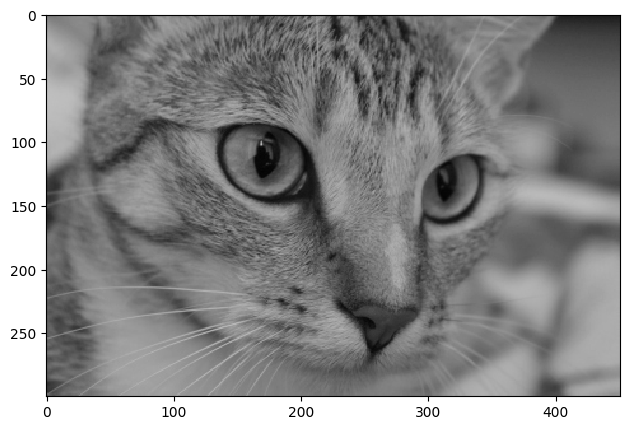

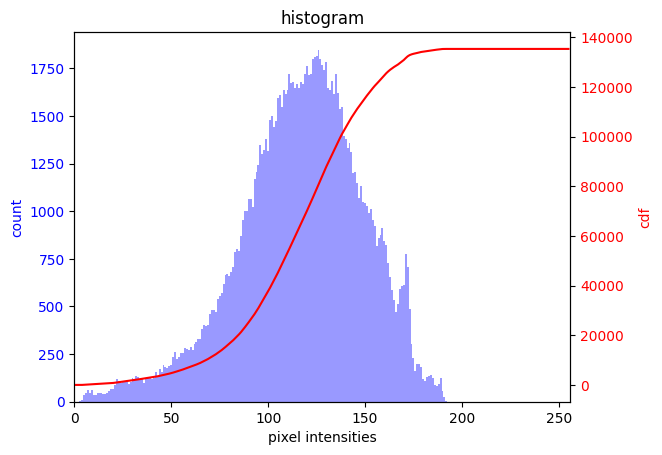

In [4]:
image = skimage.data.cat()
imGray = (skimage.color.rgb2gray(image) * 255.0).astype(np.uint8)
skimage.io.imshow(imGray)

bins, bins_c = skimage.exposure.histogram(imGray)
histogram = np.zeros(256)
np.put(histogram, bins_c, bins)

plot_histogram(histogram)

In [5]:
# implement histogram equalization
def histeq(image):
    image = skimage.exposure.equalize_hist(image) #command in library that does histogram equalization
    return image

C:\Users\marij\AppData\Local\Temp\ipykernel_34788\1717396341.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(imEq)


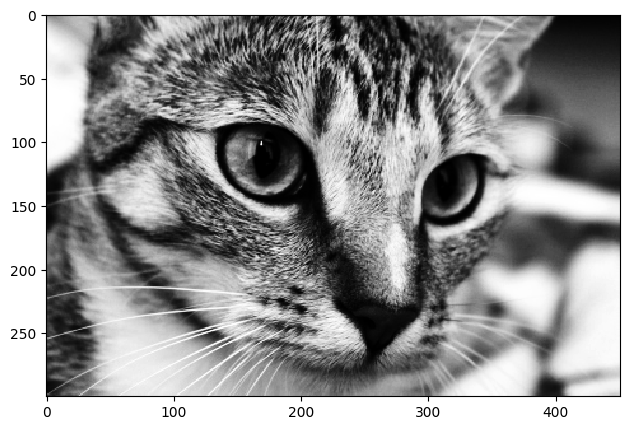

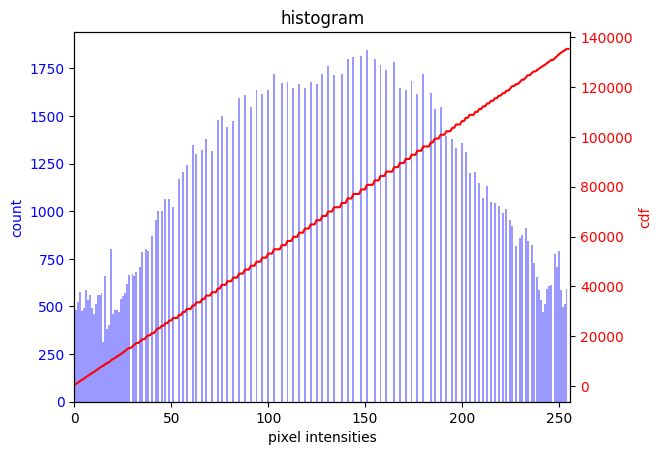

In [6]:
imEq = histeq(imGray)

skimage.io.imshow(imEq)

bins, bins_c = skimage.exposure.histogram(imEq)
histogram = np.zeros(256)
indices = (bins_c * 255).astype(int)  # convert float bin centers to integer indices
np.put(histogram, indices, bins)

plot_histogram(histogram)

#### Spatial Filtering

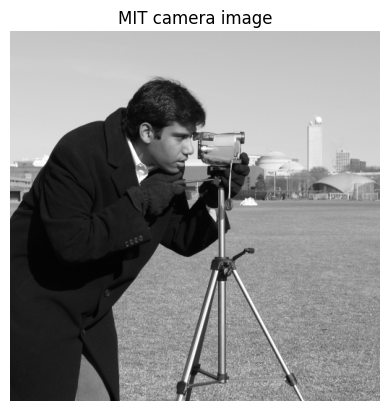

value range: 0 - 255


In [7]:
image = skimage.data.camera()

plotImage(image, "MIT camera image")

print("value range: {} - {}".format(np.min(image), np.max(image)))
  

To perform any spatial filtering, we need to implement the convolution operator. The function conv() takes an image and the filter kernel and returns the output image.

In [8]:
# Convolution function. Iterates over all input pixels and all kernel values. Divides the sums by constant.
def conv(image, filter, constant=1):
    img_height, img_width = image.shape #image size 
    kernel_height, kernel_width = filter.shape #kernel size
    
    pad_height = kernel_height // 2 #devide by 2 to get the whole number(the pading), so the image doesnt shrink
    pad_width = kernel_width // 2
    
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0) # add the bordr around the image, which is filled with 0, so  the filter can be applied to border pixels
    img_new = np.zeros_like(image) #create new image to store the result in
    
    #we take every pixel of of the image and apply filter to it
    for i in range(img_height):
        for j in range(img_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width] #take the same part of the image as the filter size
            value = np.sum(region * filter) / constant #multiply each element of that region to the filter (kernel) and sum them up,  and devide by constant (to normalize)
            img_new[i,j] = value #store thevalue in new img
    return img_new

Let us filter the image with a average/box filter. We can let the kernel size n be an argument to the function.

In [9]:
def averaging_kernel(n):
    kernel = np.ones((n, n), dtype=np.float32) #create n x n kernel filled with 1s
    return kernel

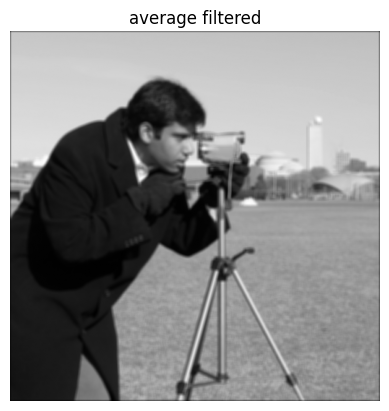

value range: 2 - 253


In [10]:
kernel = averaging_kernel(5)
imFiltered = conv(image, kernel, np.sum(kernel))

plotImage(imFiltered, "average filtered")
print("value range: {} - {}".format(np.min(imFiltered), np.max(imFiltered)))


Gaussian kernels are very popular. The values can be computed from the Gauss pdf formula. Integer valued kernels should perform best.

In [11]:
def gauss_kernel(n):
    k = n // 2 # calculate the half of the kernel (ядро) size, so the kernel is symetrical around the centere
    sigma = 1.0 #gauss parameter (big sigma - more blur, small sigma - less blur)
    kernel = np.ones((n, n), dtype=np.float32) #crate matrix filled with 1 to store the kernel values
    for i in range(-k, k + 1): #take every element of the kernel
        for j in range(-k, k + 1):
            kernel[i + k, j + k] = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-(i ** 2 + j ** 2) / (2 * sigma ** 2)) #calculate the value of the gauss function for that element
    kernel = kernel / np.sum(kernel)  # Normalize the kernel
    return kernel

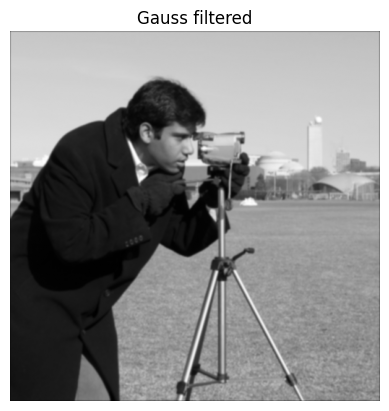

value range: 2.0 - 254.0


In [12]:
kernel = gauss_kernel(5)
imFiltered = conv(image, kernel)/np.sum(kernel)

plotImage(imFiltered, "Gauss filtered")
print("value range: {} - {}".format(np.min(imFiltered), np.max(imFiltered)))


The Sobel kernel pair is used to estimate the image gradient (vector of derivatives in x and y directions). Kernel coefficient are readily found in literature.

In [13]:
# The 3x3 Sobel kernels unnormalized
def sobel_kernels():

    # kernel for central differences i x
    Gx = np.asmatrix([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])
    
    # kernel for central differences i y 
    Gy = np.asmatrix([[-1, -2, -1],
                      [ 0,  0,  0],
                      [ 1,  2,  1]])
    
    
    return Gx, Gy

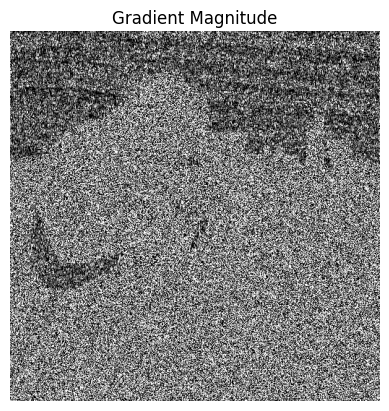

value range: 0.0 - 12.0


In [14]:
Gx, Gy = sobel_kernels()
Ix = conv(image, Gx)
Iy = conv(image, Gy)

gradMag = np.sqrt(Ix*Ix + Iy*Iy)
gradMagApprox = np.abs(Ix)+np.abs(Iy)

plotImage(gradMag, "Gradient Magnitude")
print("value range: {} - {}".format(np.min(gradMag), np.max(gradMag)))


The Laplacian kernel estimates the sum of second derivatives. We can use it to sharpen the cell image.

In [15]:
# The 3x3 Laplacian kernel (unnormalized)
def laplacian_kernel():

    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]], dtype=np.float32) #Laplacian kernel from the book and lecture
    
    return kernel 

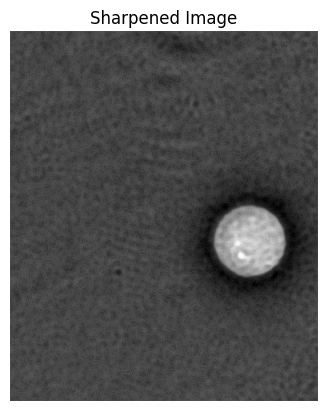

value range: 0.1 - 280.2


: 

In [ ]:
image = skimage.data.cell()
LI = conv(image, laplacian_kernel())

imSharpened = image + 0.1*LI

plotImage(imSharpened, "Sharpened Image")
print("value range: {} - {}".format(np.min(imSharpened), np.max(imSharpened)))

#### Speeding up filtering ops (optional)

You might have noticed that the filtering operations can be quite compute intensive. The following strategies can be implemented to speed up Gauss filtering:
* 1D kernels
* integer only arithmetic
* loop unrolling / reordering
* vectorizing operations
* multithreading
* GPU implementation
* frequency domain filtering
* approximate Gauss filtering

Experiment with these strategies to optimize the Gauss filter.